In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


### Make directory to save results:

In [2]:
resultsdir = '../results/N11_Predicting_Cassette_Exon_SNP_Effects/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N11_Predicting_Cassette_Exon_SNP_Effects/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load Models:

In [3]:
# Load Splice Site Model
data = sio.loadmat('../results/N7_A5SS_Model_Predictions/model_full_data.mat')
sd_scores = pd.DataFrame(index=dnatools.make_mer_list(6),data=data['Mer_scores'][:4**6*8].reshape(4**6,8)[:,2:6])
exonic_acceptor_scores = pd.read_pickle('../results/N9_Training_Joint_A5SS_A3SS_Model/exonic_acceptor_scores.series')
exonic_mer6_scores = pd.read_pickle('../results/N9_Training_Joint_A5SS_A3SS_Model/exonic_mer6_scores.series')
logit = lambda x: log(x)-log(1-x)
expit = lambda x: 1./(1.+exp(-x))

def score_seq(seq,mer_scores,mult_factor):
    score = 0.
    score += exonic_acceptor_scores.ix[seq[:3]]*mult_factor
    for b in range(len(seq)-5-6-3):
        score += mer_scores[seq[b:b+6]]*mult_factor
    # Score the SD:
    for b in range(3):
        score += sd_scores.ix[seq[len(seq)-9+b:len(seq)-9+6+b],b]*mult_factor
    return score

In [4]:
def make_exon_skipping_predictions(df,exon_seqs,mult_factor=None):
    if mult_factor==None:
        mult_factor = np.ones(len(df))*2.
    pred_psi = []
    SNP = []
    for i in range(len(df)):
        pos = int(df.POS.iloc[i])-1
        mut_seq = exon_seqs[df.Gene.iloc[i]][:pos] + df.ALT.iloc[i]+exon_seqs[df.Gene.iloc[i]][len(df.REF.iloc[i])+pos:]
        ref_seq = exon_seqs[df.Gene.iloc[i]][:pos] + df.REF.iloc[i]+exon_seqs[df.Gene.iloc[i]][len(df.REF.iloc[i])+pos:]
        if(dnatools.hamdist(mut_seq,ref_seq)==1):
            SNP.append(True)
        else:
            SNP.append(False)
        mut_score = score_seq(mut_seq,exonic_mer6_scores,mult_factor[i])
        ref_score = score_seq(ref_seq,exonic_mer6_scores,mult_factor[i])
        pred_psi.append(expit(logit(df.REF_PSI.iloc[i]/100.)+mut_score-ref_score))
    df['PSI_PRED'] = pred_psi
    df['SNP'] = SNP
    df['DPSI'] = (df.ALT_PSI-df.REF_PSI)/100.
    df['DPSI_PRED'] = df.PSI_PRED-df.REF_PSI/100.
    return df

### Load exon skipping variant data

#### SMN2

In [5]:
SMN2_exon = 'GGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGAGTAAGT'
SMN2_full_seq = 'aacttcctttattttccttacag'+SMN2_exon[:-6]+'gtaagtctgcc'
SMN2_variants = pd.read_csv('../ref/SMN2_variants.tsv',sep='\t',skiprows=4)
SMN2_variants['Gene'] = 'SMN1/2'

#### CFTR

In [6]:
CFTR_exon = 'agcagtatacaaagatgctgatttgtatttattagactctccttttggatacctagatgttttaacagaaaaagaaatatttgaaagGTATGT'.upper()
CFTR_full_seq = 'ccattttctttttagAGCAGTATACAAAGATGCTGATTTGTATTTATTAGACTCTCCTTTTGGATACCTAGATGTTTTAACAGAAAAAGAAATATTTGAAAGgtatgttctttgaat'
CFTR_variants = pd.read_csv('../ref/CFTR_variants.tsv',sep='\t',skiprows=1)
CFTR_variants['Gene'] = 'CFTR'

#### BRCA2

In [7]:
BRCA2_exon7 = 'GGTCGTCAGACACCAAAACATATTTCTGAAAGTCTAGGAGCTGAGGTGGATCCTGATATGTCTTGGTCAAGTTCTTTAGCTACACCACCCACCCTTAGTTCTACTGTGCTCATAGgtaata'.upper()
BRCA2_full_seq = 'tttctttcctcccagGGTCGTCAGACACCAAAACATATTTCTGAAAGTCTAGGAGCTGAGGTGGATCCTGATATGTCTTGGTCAAGTTCTTTAGCTACACCACCCACCCTTAGTTCTACTGTGCTCATAGgtaataatagcaaat'
BRCA2_variants = pd.read_csv('../ref/BRCA2_variants.csv',skiprows=1).fillna('')
BRCA2_variants['Gene'] = 'BRCA2'

### Make cross validation indices

In [8]:
df = pd.concat((SMN2_variants,CFTR_variants,BRCA2_variants))
df = df[pd.notnull(df.ALT_PSI)].reset_index(drop=True)
exon_seqs = {'SMN1/2':SMN2_exon,
             'CFTR':CFTR_exon,
             'BRCA2':BRCA2_exon7}
#cross_val_inds = range(len(df))
#shuffle(cross_val_inds)
#cross_val_inds = np.array(cross_val_inds)
#np.save(resultsdir+'Cross_val_inds',cross_val_inds)
cross_val_inds = np.load(resultsdir+'Cross_val_inds.npy')

We will test scaling factors between 0.5 and 4

In [9]:
def optimize_scaling_factor(df):
    scaling_factors = {}
    for i in arange(1,4,0.1):
        df = make_exon_skipping_predictions(df,exon_seqs,mult_factor=np.ones(len(df))*i)
        scaling_factors[i] = sum((df.DPSI_PRED-df.DPSI)**2)
    scaling_factors = pd.Series(scaling_factors)
    return scaling_factors.argmin()

In [10]:
cross_validated_scaling_factors = np.ones(len(df))
cross_val_group_size = len(df)/10.
for i in range(10):
    test_inds = cross_val_inds[cross_val_group_size*i:cross_val_group_size*(i+1)]
    training_inds = np.array(list(set(range(len(df)))-set(test_inds)))
    training_set = df.iloc[training_inds]
    cross_validated_scaling_factors[test_inds] = optimize_scaling_factor(training_set)
    print i,

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


0 1 2 3 4 5 6 7 8 9


/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


Make predictions with the scaling factor for the heldout variants.

In [11]:
df = make_exon_skipping_predictions(df,exon_seqs,mult_factor=cross_validated_scaling_factors)
scipy.stats.pearsonr(df.DPSI_PRED,df.DPSI)[0]**2

0.60862358629167279

In [12]:
df2write = df.copy(deep=True)
# Convert percent to fraction
df2write['REF_PSI'] = df2write['REF_PSI']/100.
df2write['ALT_PSI'] = df2write['ALT_PSI']/100.

# Add Spanr predictions for the snps
SNPs = df[(~((df.Gene=='SMN1/2')&(df.REF_PSI>50)))&df.SNP]
BRCA2_SNPS = SNPs[SNPs.Gene=='BRCA2']
SMN2_SNPs = SNPs[SNPs.Gene=='SMN1/2']
CFTR_SNPs = SNPs[SNPs.Gene=='CFTR']

BRCA2_SPANR = pd.read_csv('../ref/BRCA2_variants_SPANR.tsv',sep='\t',skiprows=4)
CFTR_SPANR = pd.read_csv('../ref/CFTR_variants_SPANR.tsv',sep='\t',skiprows=4)
SMN2_SPANR = pd.read_csv('../ref/SMN2_variants_SPANR.tsv',sep='\t',skiprows=4)
# Only look at NM_017411
SMN2_SPANR = SMN2_SPANR[SMN2_SPANR.transcript.str.contains('NM_022876')]

df2write.ix[SMN2_SNPs.index,'SPANR_dPSI'] = SMN2_SPANR.dPSI.values/100.
df2write.ix[CFTR_SNPs.index,'SPANR_dPSI'] = CFTR_SPANR.dPSI.values/100.
df2write.ix[BRCA2_SNPS.index,'SPANR_dPSI'] = BRCA2_SPANR.dPSI.values/100.

# References:
references = """# Ref 1: An extended inhibitory context causes skipping of exon 7 of SMN2 in spinal muscular atrophy
# Ref 2: In vivo selection reveals combinatorial controls that define a critical exon in the spinal muscular atrophy genes
# Ref 3: Modulating role of RNA structure in alternative splicing of a critical exon in the spinal muscular atrophy genes
# Ref 4: Determinants of Exon 7 Splicing in the Spinal Muscular Atrophy Genes SMN1 and SMN2
# Ref 5: Synonymous mutations in CFTR exon 12 affect splicing and are not neutral in evolution.
# Ref 6: Functional Analysis of a Large set of BRCA2 exon 7 Variants Highlights the Predictive Value of Hexamer Scores in Detecting Alterations of Exonic Splicing Regulatory Elements
"""

# Write references to a file 
with open(resultsdir+'Exon_Skipping_Variant_SNP_Prediction.csv','w') as f:
    f.write(references)
df2write[['Gene','POS','REF','ALT','REF_PSI','ALT_PSI',
          'DPSI','DPSI_PRED','DIR_DPSI','PSI_PRED',
          'SPANR_dPSI','SNP','ARTICLE']].to_csv(resultsdir+'Exon_Skipping_Variant_SNP_Prediction.csv',mode='a')

(0.80380275919367694, 1.1721153176468875e-30)
(0.77209750177606373, 2.5594463592896367e-05)
(0.81707261309592838, 3.9147715391293921e-10)


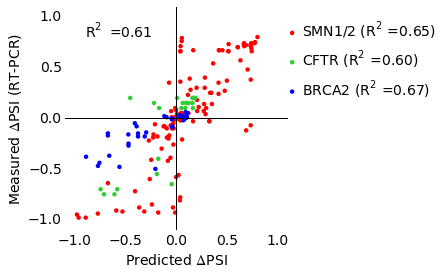

In [13]:
fig = figure(figsize=(4,4))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in df.Gene.unique():
    cur_df = df[df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.DPSI_PRED[pd.notnull(cur_df.DPSI)],cur_df.DPSI[pd.notnull(cur_df.DPSI)])[0]**2
    ax.scatter(cur_df.DPSI_PRED,cur_df.DPSI,label=gene+' ($R^2$=%0.2f)' %r2,c=colors[i],edgecolor='None')
    print scipy.stats.pearsonr(cur_df.DPSI_PRED[pd.notnull(cur_df.DPSI)],cur_df.DPSI[pd.notnull(cur_df.DPSI)])
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.72,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)

r2 = scipy.stats.pearsonr(df.DPSI_PRED[pd.notnull(df.DPSI)],
                           df.DPSI[pd.notnull(df.DPSI)])[0]**2

ax.text(-0.9,0.8,'$R^2=%0.2f$'%r2,fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)

if SAVEFIGS:
    figname = 'Scatter_predictions_all'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

Make a smaller plot for Figure 1:

(0.80380275919367694, 1.1721153176468875e-30)
(0.77209750177606373, 2.5594463592896367e-05)
(0.81707261309592838, 3.9147715391293921e-10)


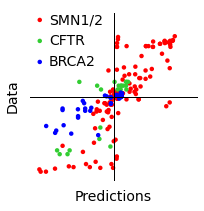

In [14]:
fig = figure(figsize=(3,3))
ax = fig.add_subplot(111)
colors = ['r','limegreen','b']
i=0
for gene in df.Gene.unique():
    cur_df = df[df.Gene==gene]
    r2 = scipy.stats.pearsonr(cur_df.DPSI_PRED[pd.notnull(cur_df.DPSI)],cur_df.DPSI[pd.notnull(cur_df.DPSI)])[0]**2
    ax.scatter(cur_df.DPSI_PRED,cur_df.DPSI,label=gene,c=colors[i],edgecolor='None')
    print scipy.stats.pearsonr(cur_df.DPSI_PRED[pd.notnull(cur_df.DPSI)],cur_df.DPSI[pd.notnull(cur_df.DPSI)])
    i+=1
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(0.5,1.08),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)
ax.axis([-1.1,1.1,-1.1,1.1])
ax.set_xticks(arange(-1,1.01,1))
ax.set_yticks(arange(-1,1.01,1))
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.tick_params(labelsize=fsize)
ax.set_xlabel('Predictions',fontsize=fsize)
ax.set_ylabel('Data',fontsize=fsize)

r2 = scipy.stats.pearsonr(df.DPSI_PRED[pd.notnull(df.DPSI)],
                           df.DPSI[pd.notnull(df.DPSI)])[0]**2

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)

if SAVEFIGS:
    figname = 'Scatter_predictions_all_small'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

In [15]:
# Get a list of SNPs 
# Only include SMN2 variants not SMN1
# Filter out SMN1, because all SMN1 variants have REF_PSI>0.5,
# while all SMN2 variants have REF_PSI<0.5
SNPs = df[(~((df.Gene=='SMN1/2')&(df.REF_PSI>50)))&df.SNP]
BRCA2_SNPS = SNPs[SNPs.Gene=='BRCA2']
SMN2_SNPs = SNPs[SNPs.Gene=='SMN1/2']
CFTR_SNPs = SNPs[SNPs.Gene=='CFTR']

In [16]:
print (sign(df[df.Gene=='SMN1/2'].DPSI)==sign(df[df.Gene=='SMN1/2'].DPSI_PRED)).sum()
print (sign(df[df.Gene=='SMN1/2'].DPSI)!=sign(df[df.Gene=='SMN1/2'].DPSI_PRED)).sum()

111
19


In [17]:
df.groupby('Gene').apply(lambda x:scipy.stats.pearsonr(x['DPSI_PRED'],x['DPSI']))

Gene
BRCA2     (0.817072613096, 3.91477153913e-10)
CFTR      (0.772097501776, 2.55944635929e-05)
SMN1/2    (0.803802759194, 1.17211531765e-30)
dtype: object

In [18]:
BRCA2_SPANR = pd.read_csv('../ref/BRCA2_variants_SPANR.tsv',sep='\t',skiprows=4)
CFTR_SPANR = pd.read_csv('../ref/CFTR_variants_SPANR.tsv',sep='\t',skiprows=4)
SMN2_SPANR = pd.read_csv('../ref/SMN2_variants_SPANR.tsv',sep='\t',skiprows=4)
# Only look at NM_017411
SMN2_SPANR = SMN2_SPANR[SMN2_SPANR.transcript.str.contains('NM_022876')]

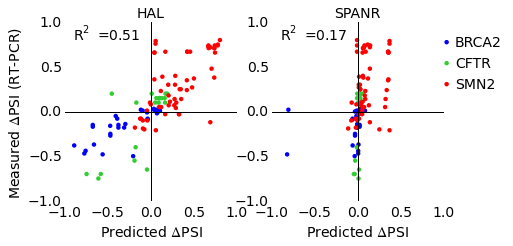

In [19]:
scaling_factor=0.8
fig = figure(figsize=(8.5*scaling_factor,4*scaling_factor))
ax = fig.add_subplot(122)
colors = ['r','limegreen','b']
i=0
ax.scatter(BRCA2_SPANR.dPSI/100.,BRCA2_SNPS.DPSI,label='BRCA2',c='b',edgecolor='None')
ax.scatter(CFTR_SPANR.dPSI/100.,CFTR_SNPs.DPSI,label='CFTR',c='limegreen',edgecolor='None')
ax.scatter(SMN2_SPANR.dPSI/100.,SMN2_SNPs.DPSI,label='SMN2',c='r',edgecolor='None')
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
ax.tick_params(labelsize=fsize)
r2 = scipy.stats.pearsonr(np.concatenate((CFTR_SPANR.dPSI.values,
                                           BRCA2_SPANR.dPSI.values,
                                           SMN2_SPANR.dPSI.values)),\
                           np.concatenate((CFTR_SNPs.DPSI.values,
                                           BRCA2_SNPS.DPSI.values,
                                           SMN2_SNPs.DPSI.values)))[0]**2
ax.text(-0.9,0.8,'$R^2=%0.2f$'%r2,fontsize=fsize)
ax.set_title('SPANR',fontsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
#ax.set_yticklabels([])
leg = ax.legend(scatterpoints=1,bbox_to_anchor=(1.4,1),fontsize=fsize,handletextpad=-0.3)
leg.get_frame().set_alpha(0)

ax = fig.add_subplot(121)
colors = ['r','limegreen','b']
i=0
ax.scatter(BRCA2_SNPS.DPSI_PRED,BRCA2_SNPS.DPSI,label='BRCA2',c='b',edgecolor='None')
ax.scatter(CFTR_SNPs.DPSI_PRED,CFTR_SNPs.DPSI,label='CFTR',c='limegreen',edgecolor='None')
ax.scatter(SMN2_SNPs.DPSI_PRED,SMN2_SNPs.DPSI,label='SMN2',c='r',edgecolor='None')

ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.axis([-1,1,-1,1]);
ax.tick_params(labelsize=fsize)
r2 = scipy.stats.pearsonr(np.concatenate((CFTR_SNPs.DPSI_PRED.values,
                                           BRCA2_SNPS.DPSI_PRED.values,
                                           BRCA2_SNPS.DPSI_PRED.values)),\
                           np.concatenate((CFTR_SNPs.DPSI.values,
                                           BRCA2_SNPS.DPSI.values,
                                           BRCA2_SNPS.DPSI.values)))[0]**2
ax.text(-0.9,0.8,'$R^2=%0.2f$'%r2,fontsize=fsize)
ax.set_title('HAL',fontsize=fsize)
ax.set_xlabel('Predicted $\Delta PSI$',fontsize=fsize)
ax.set_ylabel('Measured $\Delta PSI$ (RT-PCR)',fontsize=fsize)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(size=0)
if SAVEFIGS:
    figname = 'Scatter_predictions_comparison'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

In [20]:
SMN2_variants = make_exon_skipping_predictions(SMN2_variants,exon_seqs)
cutoff = 0.05
print 'Accuracy:',mean(sign(SMN2_variants[(SMN2_variants.DPSI.abs()>cutoff)].DPSI)==\
           sign(SMN2_variants[(SMN2_variants.DPSI.abs()>cutoff)].DPSI_PRED)),len(SMN2_variants[(SMN2_variants.DPSI.abs()>cutoff)])

Accuracy: 0.897959183673 98


In [21]:
CFTR_variants = make_exon_skipping_predictions(CFTR_variants,exon_seqs)
cutoff = 0.05
print 'Accuracy:',mean(sign(CFTR_variants[(CFTR_variants.DPSI.abs()>cutoff)].DPSI)==\
           sign(CFTR_variants[(CFTR_variants.DPSI.abs()>cutoff)].DPSI_PRED))

Accuracy: 0.863636363636


In [22]:
BRCA2_variants = make_exon_skipping_predictions(BRCA2_variants,exon_seqs)
cutoff = 0.05
print 'Accuracy:',mean(sign(BRCA2_variants[(BRCA2_variants.DPSI.abs()>cutoff)].DPSI)==\
           sign(BRCA2_variants[(BRCA2_variants.DPSI.abs()>cutoff)].DPSI_PRED))

Accuracy: 1.0


### Combine all Predictions

In [23]:
df = pd.concat((SMN2_variants,CFTR_variants,CFTR_variants))

In [24]:
print sum((BRCA2_variants.PSI_PRED>BRCA2_variants.REF_PSI/100.)==(BRCA2_variants.DPSI>0)),
print sum((BRCA2_variants.PSI_PRED>BRCA2_variants.REF_PSI/100.)==(BRCA2_variants.DPSI<0))

32 5


In [25]:
BRCA2_variants_sub = BRCA2_variants[(BRCA2_variants.DPSI.abs()>0.1)]
print sum((BRCA2_variants_sub.PSI_PRED>BRCA2_variants_sub.REF_PSI/100.)==(BRCA2_variants_sub.DPSI>0.1)),
print sum((BRCA2_variants_sub.PSI_PRED>BRCA2_variants_sub.REF_PSI/100.)==(BRCA2_variants_sub.DPSI<-0.1))

15 0


In [26]:
SMN2_stats = {}
SMN2_stats['correct'] = sum(sign(SMN2_variants.DPSI[SMN2_variants.DPSI.abs()>0])==sign(SMN2_variants.DPSI_PRED[SMN2_variants.DPSI.abs()>0]))
SMN2_stats['correct'] += (SMN2_variants[:101].DPSI_PRED>0).sum()+0.0
SMN2_stats['total'] = (SMN2_variants.DPSI.abs()>0).sum()+101.
SMN2_stats['no_change'] = sum(SMN2_variants.DPSI==0)

CFTR_stats = {}
CFTR_stats['correct'] = sum(sign(CFTR_variants.DPSI[CFTR_variants.DPSI.abs()>0])==sign(CFTR_variants.DPSI_PRED[CFTR_variants.DPSI.abs()>0]))
CFTR_stats['total'] = (CFTR_variants.DPSI.abs()>0).sum()+0.0
CFTR_stats['no_change'] = sum(CFTR_variants.DPSI==0)


BRCA2_stats = {}
BRCA2_stats['correct'] = sum(sign(BRCA2_variants.DPSI[BRCA2_variants.DPSI.abs()>0])==sign(BRCA2_variants.DPSI_PRED[BRCA2_variants.DPSI.abs()>0]))
BRCA2_stats['total'] = (BRCA2_variants.DPSI.abs()>0).sum()+0.0
BRCA2_stats['no_change'] = sum(BRCA2_variants.DPSI==0)


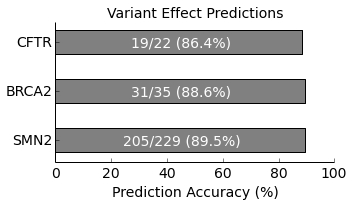

In [27]:
fig = figure(figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.barh([0,1,2],[SMN2_stats['correct']/SMN2_stats['total']*100,
                 SMN2_stats['correct']/SMN2_stats['total']*100,
                 BRCA2_stats['correct']/BRCA2_stats['total']*100],
                 height=0.5,color=[0.5,0.5,0.5])
ax.axis([0,100,-0.2,2.65])
ax.tick_params(labelsize=fsize)
ax.set_yticks([0.25,1.25,2.25])
ax.set_yticklabels(['SMN2','BRCA2','CFTR'])
ax.text(0.45*100,0.15,'%d/%d (%2.1f'%(SMN2_stats['correct'],SMN2_stats['total'],SMN2_stats['correct']/SMN2_stats['total']*100)+'%)',
        fontsize=fsize,color='w',ha='center')
ax.text(0.45*100,2.15,'%d/%d (%2.1f'%(CFTR_stats['correct'],CFTR_stats['total'],CFTR_stats['correct']/CFTR_stats['total']*100)+'%)',
        fontsize=fsize,color='w',ha='center')
ax.text(0.45*100,1.15,'%d/%d (%2.1f'%(BRCA2_stats['correct'],BRCA2_stats['total'],BRCA2_stats['correct']/BRCA2_stats['total']*100)+'%)',
        fontsize=fsize,color='w',ha='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlabel('Prediction Accuracy (%)',fontsize=fsize)
ax.set_title('Variant Effect Predictions',fontsize=fsize)
if True:
    figname = 'Bar_predictions'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### SMN2 SNP Plot

In [28]:
SMN2_SNPs = SMN2_variants[SMN2_variants.SNP & pd.notnull(SMN2_variants.DPSI) & (SMN2_variants.REF_PSI<50)]
c = 0
muts = []
refs = []
positions = []
for i in SMN2_SNPs.index:
    pos = SMN2_SNPs.POS[i]
    mut_seq = SMN2_exon[:pos] + SMN2_SNPs.ALT[i]+SMN2_exon[len(SMN2_SNPs.REF[i])+pos:]
    ref_seq = SMN2_exon[:pos] + SMN2_SNPs.REF[i]+SMN2_exon[len(SMN2_SNPs.REF[i])+pos:]  
    cur_pos = dnatools.get_snp_pos(ref_seq,mut_seq)
    muts.append(mut_seq[cur_pos])
    refs.append(ref_seq[cur_pos])
    positions.append(cur_pos)
    c+=1
SMN2_SNPs['POS'] = positions
SMN2_SNPs['REF'] = refs
SMN2_SNPs['ALT'] = muts

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


In [29]:
thresh = 0
grouped = SMN2_SNPs[SMN2_SNPs.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI.mean()
grouped_pred = SMN2_SNPs[SMN2_SNPs.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI_PRED.mean()

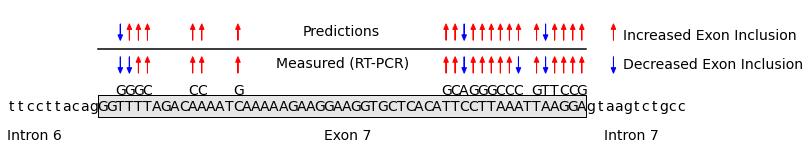

In [30]:
fsize=14
head_length = 0.05
head_width = 0.5
arrow_height = 0.1

seq = SMN2_exon[:-6]
fig = figure(figsize=(12,2))
ax = fig.add_subplot(111)
ax.add_patch(Rectangle((0, 0), len(seq), 0.2, facecolor=[0.9,0.9,0.9]))
#ax.plot([-20,0],[0.1,0.1],'k',linewidth=2)
#ax.plot([len(seq)+0.2,len(seq)+20],[0.1,0.1],'k',linewidth=2)
ax.plot([0, len(seq)], [0.62,0.62],c='k',linewidth=1.5)

for i in range(len(SMN2_full_seq[13:])):
    ax.text(i+0.5-10,0.1,SMN2_full_seq[13:][i],fontsize=fsize,va='center',ha='center')
ax.set_xlim(-10,len(seq)+10)
ax.set_ylim(-0.01,1.01)
ax.tick_params(size=0,labelsize=fsize) # labels along the bottom edge are off
ax.set_xticks(arange(len(seq))+0.5)
ax.set_xticklabels([])
ax.set_yticks([])
box('off')
for pos in grouped.index.levels[0]:
    x_offset = -0.5
    y_offset = 0.2
    ax.text(pos-0.5,y_offset+0.01,grouped.ix[pos].abs().argmax(),fontsize=fsize,ha='center')
    if (grouped.ix[pos][grouped.ix[pos].abs().argmax()]>0):
        ax.arrow( pos+x_offset, 0.2+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.2+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length )

    if grouped_pred.ix[pos][grouped.ix[pos].abs().argmax()]>0:
        ax.arrow( pos+x_offset, 0.5+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.5+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length)

ax.text(25,-0.4+y_offset,'Exon 7',ha='left',fontsize=fsize)
ax.text(-10,-0.4+y_offset,'Intron 6',ha='left',fontsize=fsize)
ax.text(56,-0.4+y_offset,'Intron 7',ha='left',fontsize=fsize)

ax.text(27,0.25+y_offset,'Measured (RT-PCR)',ha='center',fontsize=fsize)
ax.text(27,0.55+y_offset,'Predictions',ha='center',fontsize=fsize)

legend_xoffset = 3
ax.arrow(len(seq)+legend_xoffset, 0.5+0.2, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
ax.text(len(seq)+legend_xoffset+1, 0.55+0.2, 'Increased Exon Inclusion',fontsize=fsize,va='center')
ax.arrow(len(seq)+legend_xoffset, 0.0+arrow_height+head_length+y_offset+0.2, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length)
ax.text(len(seq)+legend_xoffset+1, 0.28+0.2, 'Decreased Exon Inclusion',fontsize=fsize,va='center')


if SAVEFIGS:
    figname = 'SMN2_predictions'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### CFTR SNP Plot by Position

In [31]:
thresh = 0.00
grouped = CFTR_SNPs[CFTR_SNPs.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI.mean()
grouped_pred = CFTR_SNPs[CFTR_SNPs.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI_PRED.mean()

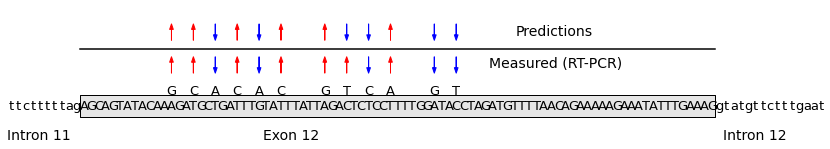

In [32]:
fsize=13
head_length = 0.05
head_width = 0.5
arrow_height = 0.1

seq = CFTR_exon[:-6]
fig = figure(figsize=(14,2))
ax = fig.add_subplot(111)
ax.add_patch(Rectangle((0, 0), len(seq), 0.2, facecolor=[0.9,0.9,0.9]))
ax.plot([0, len(seq)], [0.62,0.62],c='k',linewidth=1.5)
#ax.plot([-20,0],[0.1,0.1],'k',linewidth=2)
#ax.plot([len(seq)+0.2,len(seq)+20],[0.1,0.1],'k',linewidth=2)

for i in range(len(CFTR_full_seq[5:])):
    ax.text(i+0.5-10,0.1,CFTR_full_seq[5:][i],fontsize=fsize,va='center',ha='center')
ax.set_xlim(-10,len(seq)+10)
ax.set_ylim(-0.01,1.01)
ax.tick_params(size=0,labelsize=fsize) # labels along the bottom edge are off
ax.set_xticks(arange(len(seq))+0.5)
ax.set_xticklabels([])
ax.set_yticks([])
box('off')
for pos in grouped.index.levels[0]:
    x_offset = -0.5
    y_offset = 0.2
    ax.text(pos-0.5,y_offset+0.01,grouped.ix[pos].abs().argmax(),fontsize=fsize,ha='center')
    if (grouped.ix[pos][grouped.ix[pos].abs().argmax()]>0):
        ax.arrow( pos+x_offset, 0.2+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.2+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length )

    if grouped_pred.ix[pos][grouped.ix[pos].abs().argmax()]>0:
        ax.arrow( pos+x_offset, 0.5+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.5+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length)
fsize=14
ax.text(25,-0.4+y_offset,'Exon 12',ha='left',fontsize=fsize)
ax.text(-10,-0.4+y_offset,'Intron 11',ha='left',fontsize=fsize)
ax.text(len(seq)+1,-0.4+y_offset,'Intron 12',ha='left',fontsize=fsize)

ax.text(65,0.25+y_offset,'Measured (RT-PCR)',ha='center',fontsize=fsize)
ax.text(65,0.55+y_offset,'Predictions',ha='center',fontsize=fsize)

if True:
    figname = 'CFTR_predictions'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### BRCA2 SNP Plot by Position

In [33]:
thresh = 0.00
grouped = BRCA2_SNPS[BRCA2_SNPS.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI.mean()
grouped_pred = BRCA2_SNPS[BRCA2_SNPS.DPSI.abs()>thresh].groupby(['POS','ALT']).DPSI_PRED.mean()

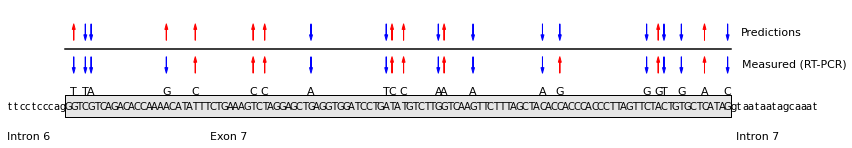

In [34]:
fsize = 11
head_length = 0.05
head_width = 0.5
arrow_height = 0.1

seq = BRCA2_exon7[:-6]
fig = figure(figsize=(14,2))
ax = fig.add_subplot(111)
ax.add_patch(Rectangle((0, 0), len(seq), 0.2, facecolor=[0.9,0.9,0.9]))
ax.plot([0, len(seq)], [0.62,0.62],c='k',linewidth=1.5)
#ax.plot([-20,0],[0.1,0.1],'k',linewidth=2)
#ax.plot([len(seq)+0.2,len(seq)+20],[0.1,0.1],'k',linewidth=2)

for i in range(len(BRCA2_full_seq[5:])):
    ax.text(i+0.5-10,0.1,BRCA2_full_seq[5:][i],fontsize=10,va='center',ha='center')
ax.set_xlim(-10,len(seq)+10)
ax.set_ylim(-0.01,1.01)
ax.tick_params(size=0,labelsize=fsize) # labels along the bottom edge are off
ax.set_xticks(arange(len(seq))+0.5)
ax.set_xticklabels([])
ax.set_yticks([])
box('off')
for pos in grouped.index.levels[0]:
    x_offset = -0.5
    y_offset = 0.2
    ax.text(pos-0.5,y_offset+0.01,grouped.ix[pos].abs().argmax(),fontsize=fsize,ha='center')
    if (grouped.ix[pos][grouped.ix[pos].abs().argmax()]>0):
        ax.arrow( pos+x_offset, 0.2+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.2+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length )

    if grouped_pred.ix[pos][grouped.ix[pos].abs().argmax()]>0:
        ax.arrow( pos+x_offset, 0.5+y_offset, 0.0, arrow_height, fc="r", ec="r",
                 head_width=head_width, head_length=head_length )
    else:
        ax.arrow( pos+x_offset, 0.5+arrow_height+head_length+y_offset, 0.0, -arrow_height, fc="b", ec="b",
                 head_width=head_width, head_length=head_length)
ax.text(25,-0.4+y_offset,'Exon 7',ha='left',fontsize=fsize)
ax.text(-10,-0.4+y_offset,'Intron 6',ha='left',fontsize=fsize)
ax.text(len(seq)+1,-0.4+y_offset,'Intron 7',ha='left',fontsize=fsize)

ax.text(len(seq)+2,0.25+y_offset,'Measured (RT-PCR)',ha='left',fontsize=fsize)
ax.text(len(seq)+2,0.55+y_offset,'Predictions',ha='left',fontsize=fsize)

if SAVEFIGS:
    figname = 'BRCA2_predictions'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')

### Paper Statistics:

#### SMN1/2

In [35]:
# SMN2 with RT-PCR data:
correct = sum(sign(SMN2_variants.DPSI[SMN2_variants.DPSI.abs()>0])==sign(SMN2_variants.DPSI_PRED[SMN2_variants.DPSI.abs()>0]))
total = SMN2_stats['total'] = (SMN2_variants.DPSI.abs()>0).sum()
print correct,total,float(correct)/total
print scipy.stats.pearsonr(SMN2_variants.DPSI[SMN2_variants.DPSI.abs()>=0],
                           SMN2_variants.DPSI_PRED[SMN2_variants.DPSI.abs()>=0])[0]**2

111 128 0.8671875
0.57243885527


In [36]:
sum(SMN2_variants.REF.apply(len)==SMN2_variants.ALT.apply(len))

219

In [37]:
inds = find(SMN2_variants.REF.apply(len)>SMN2_variants.ALT.apply(len))
SMN2_variants.iloc[inds]
mean(sign(SMN2_variants.iloc[inds].DPSI)==sign(SMN2_variants.iloc[inds].DPSI_PRED))

1.0

In [38]:
inds = find(SMN2_variants.REF.apply(len)<SMN2_variants.ALT.apply(len))
SMN2_variants.iloc[inds]
sum(sign(SMN2_variants.iloc[inds].DPSI)==sign(SMN2_variants.iloc[inds].DPSI_PRED))

3

In [39]:
mean(sign(df[df.Gene=='BRCA2'].DPSI[df[df.Gene=='BRCA2'].DPSI.abs()>0.1])==sign(df[df.Gene=='BRCA2'].DPSI_PRED[df[df.Gene=='BRCA2'].DPSI.abs()>0.1]))

nan

In [40]:
sign(df[df.Gene=='BRCA2'].DPSI).shape

(0,)

In [41]:
thresh = 0.05
sum(sign(df[df.Gene=='BRCA2'].DPSI[df[df.Gene=='BRCA2'].DPSI.abs()>thresh])==sign(df[df.Gene=='BRCA2'].DPSI_PRED[df[df.Gene=='BRCA2'].DPSI.abs()>thresh]))

0